# Neural Networks to predict protein activation

### Improvement ideas
* Look at one hot key encoding, are we dropping one of the 21 features? do we need to do so?
* One vector with four 1s, we might be loosing information
* Class weights
* Number of epochs
* batch size
* Neural Network (number of layers, where to put drop out layer, activations)
* Optimizer, loss function for f1

#### Set up the directories, load libraries

In [0]:
import pandas as pd
import numpy as np

import pickle
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import keras
import keras.backend as K
from keras import Sequential

from keras.layers import Dense, Dropout, Activation
from keras.layers import BatchNormalization
from keras.layers import AlphaDropout

from keras.regularizers import l2

from keras import regularizers
from keras.optimizers import SGD
from keras.callbacks import Callback,ModelCheckpoint, EarlyStopping
from keras import initializers

from matplotlib import pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder

In [0]:
tf.test.gpu_device_name()
from keras import backend as K
import keras.backend.tensorflow_backend as tfback
def _get_available_gpus():  

    if tfback._LOCAL_DEVICES is None:  
        devices = tf.config.list_logical_devices()  
        tfback._LOCAL_DEVICES = [x.name for x in devices]  
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]


tfback._get_available_gpus = _get_available_gpus
tfback._get_available_gpus()

[]

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4654183163136582772, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14271898885776931737
 physical_device_desc: "device: XLA_CPU device"]

In [0]:
#!if [ ! -f Archive.zip ]; then wget -nv https://drive.google.com/open?id=1g7aT8cMkFAFlk6wxkiEH3mgFVp2Xa1l9 -O Archive.zip; fi

In [0]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount= True)
# import os
# os.chdir("/content/drive/My Drive/IML/IML_Projects/task_3")
# os.getcwd()

In [0]:
import os
os.getcwd()

'/content'

In [0]:
! ls

Data  models  sample_data


#### Load data & data inspection

In [0]:
dat_train = pd.read_csv("./Data/train.csv")
dat_test = pd.read_csv("./Data/test.csv")

In [0]:
# check class balance on activation
dat_train['Active'].value_counts()

0    107787
1      4213
Name: Active, dtype: int64

In [0]:
dat_train.iloc[np.where(dat_train['Active'] == 1)]

,Sequence,Active
77,IHGS,1
91,KSYG,1
102,LCLA,1
122,YYCV,1
164,VVGS,1
...,...,...
111823,YTCG,1
111850,VSGA,1
111875,FTGS,1
111879,LRLV,1


#### Pre-process data

In [0]:
import re

def split_convert(word_inp): 
    return [ord(i) for i in word_inp] 

In [0]:
train_seqs = [split_convert(i) for i in dat_train.iloc[:,0]]
train_labels = [i for i in dat_train.iloc[:,1]]
test_seqs = [split_convert(i) for i in dat_test.iloc[:,0]]

In [0]:
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
train_seqs_onehot = onehot_encoder.fit_transform(train_seqs)
test_seqs_onehot = onehot_encoder.transform(test_seqs)

#### Define Neural Network Architecture and Model

In [0]:
# functions to determine metrics f1, precision and recall
# taken from: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

def get_recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def get_precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def get_f1(y_true, y_pred):
    precision = get_precision(y_true, y_pred)
    recall = get_recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def macro_double_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    This version uses the computation of soft-F1 for both positive and negative class for each label.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    tn = tf.reduce_sum((1 - y_hat) * (1 - y), axis=0)
    soft_f1_class1 = 2*tp / (2*tp + fn + fp + 1e-16)
    soft_f1_class0 = 2*tn / (2*tn + fn + fp + 1e-16)
    cost_class1 = 1 - soft_f1_class1 # reduce 1 - soft-f1_class1 in order to increase soft-f1 on class 1
    cost_class0 = 1 - soft_f1_class0 # reduce 1 - soft-f1_class0 in order to increase soft-f1 on class 0
    cost = 0.5 * (cost_class1 + cost_class0) # take into account both class 1 and class 0
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [0]:
# determine class imbalance
class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
class_weight_dict = dict(enumerate(class_weights))

In [0]:
# class_weight = {0:1, 1:12}
NEPOCHS = 200
BATCHSIZE = 250
VALIDATIONSPLIT = 0.2
HIDDENSIZE = 80
SEED = 42



In [0]:
os.environ['PYTHONHASHSEED']=str(SEED)

tf.random.set_seed(SEED)

from numpy.random import seed
seed(SEED)

In [0]:
# opt = SGD(lr=0.01, momentum=0.9)


opt = keras.optimizers.Adam(clipnorm = 12)
kernel_l2_regularizer =  2.5 * 1 * 1e-5
kernel_l1_regularizer = 0#1 * 1e-4
activity_l2_regularizer = 0#1 * 1e-5

HIDDENLAYER0 = 60
HIDDENLAYER1 = 60
HIDDENLAYER2 = 90
HIDDENLAYER3 = HIDDENLAYER1

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps= int(112000 * 0.9 / BATCHSIZE) * 1000,
  decay_rate=1,
  staircase=False)
opt = tf.keras.optimizers.Adam(lr_schedule)

def create_model():
  model = Sequential()
  model.add(Dense(HIDDENLAYER0, input_dim = 80, activation= None,
                  kernel_initializer= initializers.lecun_normal(seed=SEED),
                  kernel_regularizer=l2(kernel_l2_regularizer)))
  # model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Dense(HIDDENLAYER1, input_dim = HIDDENLAYER0, activation= None, 
                  kernel_initializer= initializers.lecun_normal(seed=SEED),
                  kernel_regularizer=l2(kernel_l2_regularizer)))
  # model.add(BatchNormalization())
  model.add(Activation('relu'))
  # model.add(AlphaDropout(rate = 0.5, seed = SEED))
  model.add(Dropout(rate = 0.5))
  model.add(BatchNormalization())

  model.add(Dense(1, input_dim = HIDDENLAYER1, activation='sigmoid',
                  kernel_initializer= initializers.lecun_normal(seed=SEED)))

  model.compile(optimizer=opt,
                loss="binary_crossentropy",
 #               loss='mean_squared_error',
                metrics=['accuracy', get_f1])

  return model


In [0]:
def plot_loss_f1(model):
  plt.plot(model.history['get_f1'])
  plt.plot(model.history['val_get_f1'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(model.history['loss'])
  plt.plot(model.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()


#### Model Selection / training

In [0]:
kfold_splits = 10
folds = list(StratifiedKFold(n_splits=kfold_splits, shuffle=True, random_state=SEED).split(train_seqs_onehot, train_labels))

In [0]:
device_name = tf.test.gpu_device_name()
device_name

''

In [0]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_229 (Dense)            (None, 60)                4860      
_________________________________________________________________
activation_41 (Activation)   (None, 60)                0         
_________________________________________________________________
dense_230 (Dense)            (None, 60)                3660      
_________________________________________________________________
activation_42 (Activation)   (None, 60)                0         
_________________________________________________________________
dropout_77 (Dropout)         (None, 60)                0         
_________________________________________________________________
batch_normalization_78 (Batc (None, 60)                240       
_________________________________________________________________
dense_231 (Dense)            (None, 1)               

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


 - 1s - loss: 0.1588 - accuracy: 0.9431 - get_f1: 0.5490 - val_loss: 0.1556 - val_accuracy: 0.9479 - val_get_f1: 0.5760
Epoch 3/200
 - 1s - loss: 0.1142 - accuracy: 0.9571 - get_f1: 0.6189 - val_loss: 0.1088 - val_accuracy: 0.9645 - val_get_f1: 0.6619
Epoch 4/200
 - 1s - loss: 0.0946 - accuracy: 0.9650 - get_f1: 0.6687 - val_loss: 0.0992 - val_accuracy: 0.9680 - val_get_f1: 0.6902
Epoch 5/200
 - 1s - loss: 0.0818 - accuracy: 0.9684 - get_f1: 0.6884 - val_loss: 0.0862 - val_accuracy: 0.9728 - val_get_f1: 0.7211
Epoch 6/200
 - 1s - loss: 0.0717 - accuracy: 0.9713 - get_f1: 0.7104 - val_loss: 0.0732 - val_accuracy: 0.9755 - val_get_f1: 0.7429
Epoch 7/200
 - 1s - loss: 0.0643 - accuracy: 0.9743 - get_f1: 0.7319 - val_loss: 0.0806 - val_accuracy: 0.9759 - val_get_f1: 0.7462
Epoch 8/200
 - 1s - loss: 0.0587 - accuracy: 0.9767 - get_f1: 0.7514 - val_loss: 0.0633 - val_accuracy: 0.9788 - val_get_f1: 0.7706
Epoch 9/200
 - 1s - loss: 0.0552 - accuracy: 0.9776 - get_f1: 0.7601 - val_loss: 0.0691 

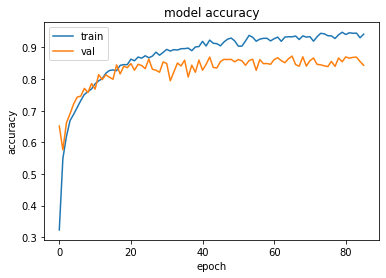

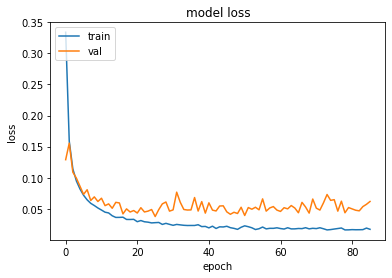

11200/11200 [==============================] - 0s 5us/step
Number of positive predicted samples in the validation set:  476
100800/100800 [==============================] - 0s 3us/step
Number of positive predicted samples in the train set:  476
F1 score for this fold is :  0.867335562987737 0.9323141412896068
Training on fold 2/10...
Train on 100800 samples, validate on 11200 samples
Epoch 1/200
 - 1s - loss: 0.1977 - accuracy: 0.9195 - get_f1: 0.5133 - val_loss: 0.1036 - val_accuracy: 0.9654 - val_get_f1: 0.6573
Epoch 2/200
 - 1s - loss: 0.1115 - accuracy: 0.9631 - get_f1: 0.6527 - val_loss: 0.1198 - val_accuracy: 0.9621 - val_get_f1: 0.6504
Epoch 3/200
 - 1s - loss: 0.0887 - accuracy: 0.9693 - get_f1: 0.6950 - val_loss: 0.1165 - val_accuracy: 0.9643 - val_get_f1: 0.6652
Epoch 4/200
 - 1s - loss: 0.0745 - accuracy: 0.9731 - get_f1: 0.7224 - val_loss: 0.0819 - val_accuracy: 0.9737 - val_get_f1: 0.7225
Epoch 5/200
 - 1s - loss: 0.0657 - accuracy: 0.9768 - get_f1: 0.7447 - val_loss: 0.07

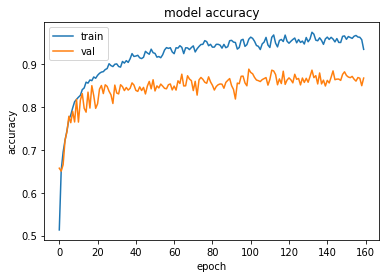

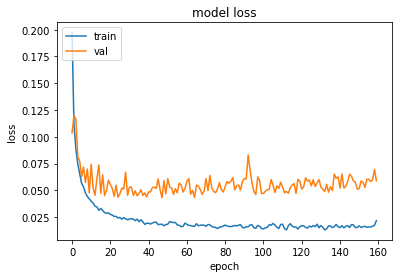

11200/11200 [==============================] - 0s 6us/step
Number of positive predicted samples in the validation set:  446
100800/100800 [==============================] - 0s 3us/step
Number of positive predicted samples in the train set:  446
F1 score for this fold is :  0.8973471741637831 0.9873714360109361
Training on fold 3/10...
Train on 100800 samples, validate on 11200 samples
Epoch 1/200
 - 1s - loss: 0.2137 - accuracy: 0.9129 - get_f1: 0.4994 - val_loss: 0.1066 - val_accuracy: 0.9642 - val_get_f1: 0.6457
Epoch 2/200
 - 1s - loss: 0.1269 - accuracy: 0.9577 - get_f1: 0.6214 - val_loss: 0.1285 - val_accuracy: 0.9564 - val_get_f1: 0.6167
Epoch 3/200
 - 1s - loss: 0.1025 - accuracy: 0.9652 - get_f1: 0.6677 - val_loss: 0.0981 - val_accuracy: 0.9677 - val_get_f1: 0.6839
Epoch 4/200
 - 1s - loss: 0.0838 - accuracy: 0.9715 - get_f1: 0.7095 - val_loss: 0.0981 - val_accuracy: 0.9675 - val_get_f1: 0.6853
Epoch 5/200
 - 1s - loss: 0.0725 - accuracy: 0.9739 - get_f1: 0.7270 - val_loss: 0.0

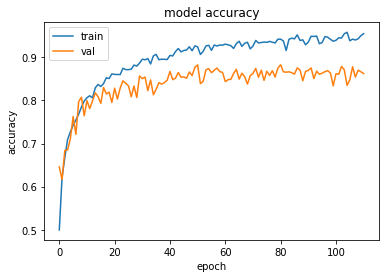

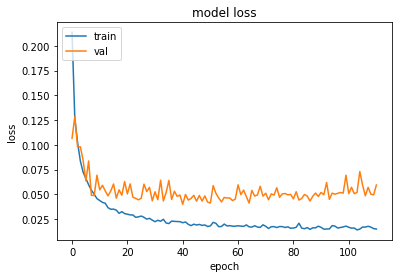

11200/11200 [==============================] - 0s 6us/step
Number of positive predicted samples in the validation set:  463
100800/100800 [==============================] - 0s 3us/step
Number of positive predicted samples in the train set:  463
F1 score for this fold is :  0.8846153846153846 0.9542763572238318
Training on fold 4/10...
Train on 100800 samples, validate on 11200 samples
Epoch 1/200
 - 1s - loss: 0.2214 - accuracy: 0.9098 - get_f1: 0.4887 - val_loss: 0.0945 - val_accuracy: 0.9717 - val_get_f1: 0.6904
Epoch 2/200
 - 1s - loss: 0.1247 - accuracy: 0.9565 - get_f1: 0.6140 - val_loss: 0.0938 - val_accuracy: 0.9688 - val_get_f1: 0.6848
Epoch 3/200
 - 1s - loss: 0.0970 - accuracy: 0.9654 - get_f1: 0.6694 - val_loss: 0.1282 - val_accuracy: 0.9600 - val_get_f1: 0.6410
Epoch 4/200
 - 1s - loss: 0.0813 - accuracy: 0.9707 - get_f1: 0.7065 - val_loss: 0.0992 - val_accuracy: 0.9678 - val_get_f1: 0.6835
Epoch 5/200
 - 1s - loss: 0.0718 - accuracy: 0.9734 - get_f1: 0.7242 - val_loss: 0.0

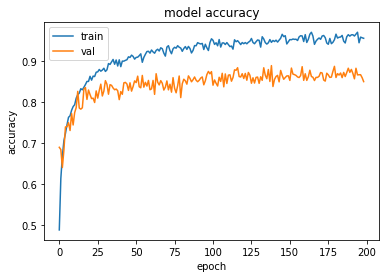

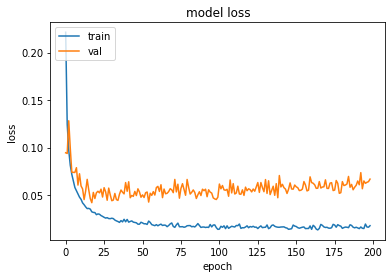

11200/11200 [==============================] - 0s 6us/step
Number of positive predicted samples in the validation set:  430
100800/100800 [==============================] - 0s 3us/step
Number of positive predicted samples in the train set:  430
F1 score for this fold is :  0.8954171562867215 0.9878827361563518
Training on fold 5/10...
Train on 100800 samples, validate on 11200 samples
Epoch 1/200
 - 1s - loss: 0.2155 - accuracy: 0.9054 - get_f1: 0.4892 - val_loss: 0.0979 - val_accuracy: 0.9698 - val_get_f1: 0.6904
Epoch 2/200
 - 1s - loss: 0.1228 - accuracy: 0.9565 - get_f1: 0.6162 - val_loss: 0.0983 - val_accuracy: 0.9670 - val_get_f1: 0.6754
Epoch 3/200
 - 1s - loss: 0.0977 - accuracy: 0.9641 - get_f1: 0.6586 - val_loss: 0.1106 - val_accuracy: 0.9643 - val_get_f1: 0.6645
Epoch 4/200
 - 1s - loss: 0.0844 - accuracy: 0.9693 - get_f1: 0.6973 - val_loss: 0.0949 - val_accuracy: 0.9696 - val_get_f1: 0.6997
Epoch 5/200
 - 1s - loss: 0.0725 - accuracy: 0.9722 - get_f1: 0.7168 - val_loss: 0.0

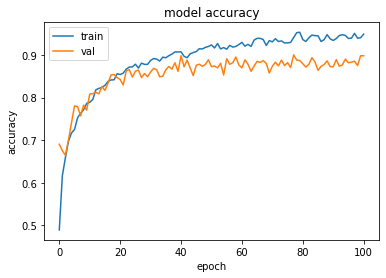

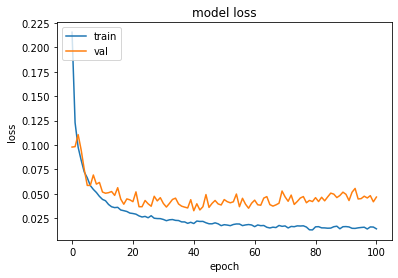

11200/11200 [==============================] - 0s 6us/step
Number of positive predicted samples in the validation set:  468
100800/100800 [==============================] - 0s 3us/step
Number of positive predicted samples in the train set:  468
F1 score for this fold is :  0.904386951631046 0.9484355444305382
Training on fold 6/10...
Train on 100800 samples, validate on 11200 samples
Epoch 1/200
 - 1s - loss: 0.2416 - accuracy: 0.8893 - get_f1: 0.4470 - val_loss: 0.1063 - val_accuracy: 0.9698 - val_get_f1: 0.6839
Epoch 2/200
 - 1s - loss: 0.1320 - accuracy: 0.9540 - get_f1: 0.6016 - val_loss: 0.1265 - val_accuracy: 0.9605 - val_get_f1: 0.6366
Epoch 3/200
 - 1s - loss: 0.1062 - accuracy: 0.9624 - get_f1: 0.6501 - val_loss: 0.0999 - val_accuracy: 0.9683 - val_get_f1: 0.6828
Epoch 4/200
 - 1s - loss: 0.0894 - accuracy: 0.9675 - get_f1: 0.6813 - val_loss: 0.0920 - val_accuracy: 0.9709 - val_get_f1: 0.7015
Epoch 5/200
 - 1s - loss: 0.0796 - accuracy: 0.9713 - get_f1: 0.7083 - val_loss: 0.08

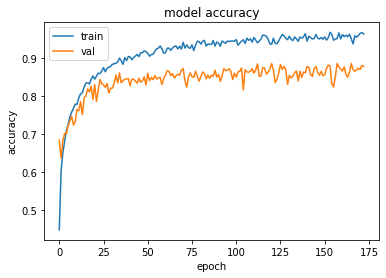

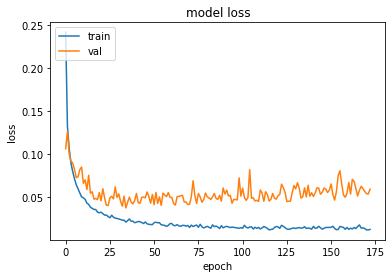

11200/11200 [==============================] - 0s 6us/step
Number of positive predicted samples in the validation set:  475
100800/100800 [==============================] - 0s 3us/step
Number of positive predicted samples in the train set:  475
F1 score for this fold is :  0.8973214285714285 0.9675855028075548
Training on fold 7/10...
Train on 100800 samples, validate on 11200 samples
Epoch 1/200
 - 1s - loss: 0.2405 - accuracy: 0.8941 - get_f1: 0.4595 - val_loss: 0.1034 - val_accuracy: 0.9718 - val_get_f1: 0.6994
Epoch 2/200
 - 1s - loss: 0.1400 - accuracy: 0.9545 - get_f1: 0.6027 - val_loss: 0.1155 - val_accuracy: 0.9652 - val_get_f1: 0.6683
Epoch 3/200
 - 1s - loss: 0.1071 - accuracy: 0.9632 - get_f1: 0.6531 - val_loss: 0.1414 - val_accuracy: 0.9585 - val_get_f1: 0.6357
Epoch 4/200
 - 1s - loss: 0.0893 - accuracy: 0.9675 - get_f1: 0.6847 - val_loss: 0.0952 - val_accuracy: 0.9712 - val_get_f1: 0.7148
Epoch 5/200
 - 1s - loss: 0.0765 - accuracy: 0.9725 - get_f1: 0.7189 - val_loss: 0.0

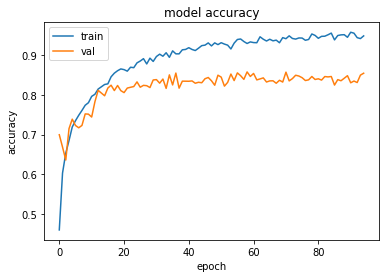

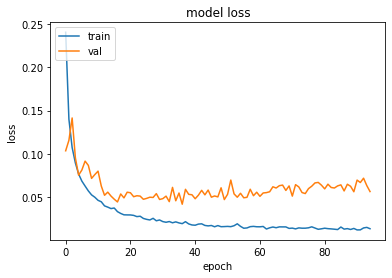

11200/11200 [==============================] - 0s 6us/step
Number of positive predicted samples in the validation set:  494
100800/100800 [==============================] - 0s 4us/step
Number of positive predicted samples in the train set:  494
F1 score for this fold is :  0.8524590163934426 0.9428145201392342
Training on fold 8/10...
Train on 100800 samples, validate on 11200 samples
Epoch 1/200
 - 1s - loss: 0.2448 - accuracy: 0.8864 - get_f1: 0.4398 - val_loss: 0.1048 - val_accuracy: 0.9704 - val_get_f1: 0.6856
Epoch 2/200
 - 1s - loss: 0.1385 - accuracy: 0.9497 - get_f1: 0.5791 - val_loss: 0.1419 - val_accuracy: 0.9525 - val_get_f1: 0.5964
Epoch 3/200
 - 1s - loss: 0.1099 - accuracy: 0.9595 - get_f1: 0.6349 - val_loss: 0.0945 - val_accuracy: 0.9674 - val_get_f1: 0.6790
Epoch 4/200
 - 1s - loss: 0.0945 - accuracy: 0.9653 - get_f1: 0.6702 - val_loss: 0.1105 - val_accuracy: 0.9628 - val_get_f1: 0.6543
Epoch 5/200
 - 1s - loss: 0.0834 - accuracy: 0.9686 - get_f1: 0.6919 - val_loss: 0.1

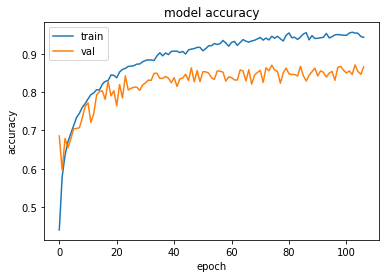

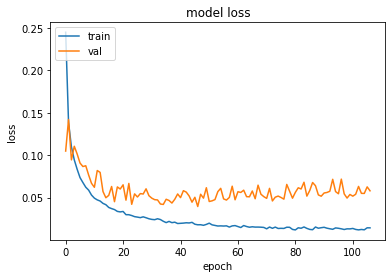

11200/11200 [==============================] - 0s 6us/step
Number of positive predicted samples in the validation set:  476
100800/100800 [==============================] - 0s 3us/step
Number of positive predicted samples in the train set:  476
F1 score for this fold is :  0.8685968819599109 0.9529559748427672
Training on fold 9/10...
Train on 100800 samples, validate on 11200 samples
Epoch 1/200
 - 1s - loss: 0.2437 - accuracy: 0.8817 - get_f1: 0.4453 - val_loss: 0.1043 - val_accuracy: 0.9700 - val_get_f1: 0.6887
Epoch 2/200
 - 1s - loss: 0.1351 - accuracy: 0.9537 - get_f1: 0.6001 - val_loss: 0.1147 - val_accuracy: 0.9633 - val_get_f1: 0.6592
Epoch 3/200
 - 1s - loss: 0.1064 - accuracy: 0.9620 - get_f1: 0.6465 - val_loss: 0.1049 - val_accuracy: 0.9660 - val_get_f1: 0.6765
Epoch 4/200
 - 1s - loss: 0.0905 - accuracy: 0.9668 - get_f1: 0.6793 - val_loss: 0.0897 - val_accuracy: 0.9712 - val_get_f1: 0.7075
Epoch 5/200
 - 1s - loss: 0.0811 - accuracy: 0.9707 - get_f1: 0.7039 - val_loss: 0.1

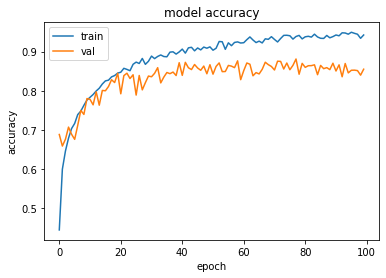

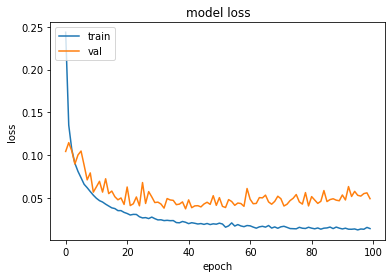

11200/11200 [==============================] - 0s 5us/step
Number of positive predicted samples in the validation set:  478
100800/100800 [==============================] - 0s 3us/step
Number of positive predicted samples in the train set:  478
F1 score for this fold is :  0.8777777777777778 0.9405485912870796
Training on fold 10/10...
Train on 100800 samples, validate on 11200 samples
Epoch 1/200
 - 1s - loss: 0.2574 - accuracy: 0.8736 - get_f1: 0.4199 - val_loss: 0.1315 - val_accuracy: 0.9613 - val_get_f1: 0.6260
Epoch 2/200
 - 1s - loss: 0.1480 - accuracy: 0.9489 - get_f1: 0.5748 - val_loss: 0.1205 - val_accuracy: 0.9614 - val_get_f1: 0.6413
Epoch 3/200
 - 1s - loss: 0.1216 - accuracy: 0.9578 - get_f1: 0.6233 - val_loss: 0.1092 - val_accuracy: 0.9650 - val_get_f1: 0.6667
Epoch 4/200
 - 1s - loss: 0.1077 - accuracy: 0.9626 - get_f1: 0.6494 - val_loss: 0.0937 - val_accuracy: 0.9707 - val_get_f1: 0.7013
Epoch 5/200
 - 1s - loss: 0.0928 - accuracy: 0.9675 - get_f1: 0.6828 - val_loss: 0.

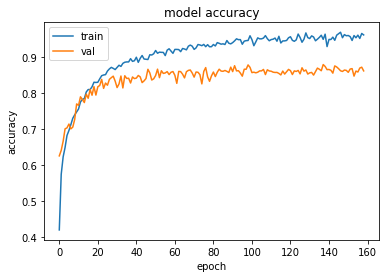

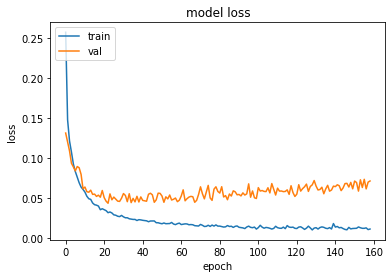

11200/11200 [==============================] - 0s 6us/step
Number of positive predicted samples in the validation set:  450
100800/100800 [==============================] - 0s 3us/step
Number of positive predicted samples in the train set:  450
F1 score for this fold is :  0.8853211009174311 0.9779383305379951


In [103]:
# Convert labels to categorical one-hot encoding
#train_labels_onehot = keras.utils.to_categorical(train_labels, num_classes=2)

mode_path = './models/mlp_v2.h5'

model = None
model = create_model()
model.summary()

best_fold = -1
best_score = 0
best_model = None

for index, (train_indices, val_indices) in enumerate(folds):

  print("Training on fold " + str(index+1) + "/10...")

  # Generate batches from indices
  xtrain, xval = train_seqs_onehot[train_indices], train_seqs_onehot[val_indices]
  #ytrain, yval = train_labels_onehot[train_indices], train_labels_onehot[val_indices]
  ytrain = np.array(train_labels)[train_indices.astype(int)]
  yval = np.array(train_labels)[val_indices.astype(int)]

  # xtrain_onehot = onehot_encoder.transform(xtrain)
  # xval_onehot = onehot_encoder.transform(xval)
  # ytrain_onehot = keras.utils.to_categorical(y_train, num_classes=2)
  # yval_onehot = keras.utils.to_categorical(y_val, num_classes=2)

  model = None
  model = create_model()

  # class wight for the train set
  class_weights = class_weight.compute_class_weight('balanced', np.unique(ytrain), ytrain)
  class_weight_dict = dict(enumerate(class_weights))

  # model.summary()
  with tf.device('/device:GPU:0'):
    callbacks = [ModelCheckpoint(filepath=mode_path, save_best_only=True),
                 EarlyStopping(monitor="val_get_f1", min_delta=0.01, patience=60, mode="max", baseline = 0.6,
                            restore_best_weights = True, verbose = 1)]

    history = model.fit(xtrain, ytrain, validation_data = (xval, yval), epochs = NEPOCHS, batch_size=BATCHSIZE, verbose = 2,
              callbacks=callbacks, class_weight = class_weight_dict)  # starts training

  plot_loss_f1(history)

  # get the best fold based on the best f1 score
  y_pred = model.predict_classes(xval, batch_size=BATCHSIZE, verbose=1)
  print("Number of positive predicted samples in the validation set: ", np.sum(y_pred))

  y_train = model.predict_classes(xtrain, batch_size=BATCHSIZE, verbose=1)
  print("Number of positive predicted samples in the train set: ", np.sum(y_pred))

  y_pred_bool = y_pred.astype(int)
  tmp_score = metrics.f1_score(yval,y_pred)
  score_train = metrics.f1_score(ytrain,y_train)
  print("F1 score for this fold is : ", tmp_score, score_train)

  if(tmp_score > best_score):
    best_fold = index
    best_model = model


In [114]:
# train model on entire data set
# class wight for the train set
class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
class_weight_dict = dict(enumerate(class_weights))

# model.summary()
callbacks = [EarlyStopping(monitor="get_f1", min_delta=0.01, patience=80, mode="max", baseline = 0.6,
                            restore_best_weights = True, verbose = 1)]

with tf.device('/device:GPU:0'):
  model.fit(train_seqs_onehot,train_labels, validation_split=0, epochs = NEPOCHS, batch_size=BATCHSIZE, verbose = 0 ,
            callbacks=callbacks, class_weight = class_weight_dict)  # starts training

Restoring model weights from the end of the best epoch
Epoch 00081: early stopping


In [116]:
# Training Error
y_pred = model.predict_classes(train_seqs_onehot, batch_size=BATCHSIZE, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(train_labels, y_pred))

112000/112000 [==============================] - 0s 4us/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    107787
           1       0.99      1.00      0.99      4213

    accuracy                           1.00    112000
   macro avg       0.99      1.00      1.00    112000
weighted avg       1.00      1.00      1.00    112000



#### Prediction on test data

In [117]:
y_pred = model.predict_classes(test_seqs_onehot, batch_size=BATCHSIZE,verbose = 1)
# res = np.argmax(y_pred, axis=1)
print(np.sum(y_pred))

# res = pd.DataFrame(res)
res = pd.DataFrame(y_pred)

48000/48000 [==============================] - 0s 4us/step
1935


#### Save results

In [0]:
res.to_csv("./prediction.csv", index=False, header=False)